In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
%matplotlib inline
# import stats as sts 

In [2]:
#read analyst actuals file
column_names1 = ['TICKER','ANNDATS','quarternum','earn_value']
df_actual_ern=pd.read_csv("../AFE_data/df_actual_ern.csv", header = None, names = column_names1)
#df_actual_ern = pd.read_csv('/Users/Blair/Downloads/AFE_data/df_actual_ern.csv')
#read analyst forecast file
column_names2 = ['TICKER','ANNDATS','quarternum','analyst','forecast_value']
df_aforcast=pd.read_csv("../AFE_data/df_aforecast.csv", header = None, names = column_names2)
#df_aforecast = pd.read_csv('/Users/Blair/Downloads/AFE_data/df_aforecast.csv')

In [3]:
#Set Year
df_actual_ern['year'] = df_actual_ern['ANNDATS'].apply(lambda x: str(x)[:4])

df_aforcast['year'] = df_aforcast['ANNDATS'].apply(lambda x: str(x)[:4])

In [4]:
#Merge two datasets
merged = pd.merge(df_aforcast,df_actual_ern,how = 'inner', on = ['TICKER','quarternum','year'])
merged.head()

,TICKER,ANNDATS_x,quarternum,analyst,forecast_value,year,ANNDATS_y,earn_value
0,AA,19961231,3,3700,4.3125,1996,19961004,0.5775
1,AA,19961231,3,281,4.1250,1996,19961004,0.5775
2,AA,19961231,3,4088,3.1875,1996,19961004,0.5775
3,AA,19971231,3,662,3.0000,1997,19971006,0.9375
4,AA,19971231,3,472,3.9375,1997,19971006,0.9375


In [79]:
x = (merged['forecast_value']/merged['earn_value']).dropna()
x[abs(x)<500].mean()


3.9040134873693755

In [6]:
#Surprise Matrics
merged.index = merged[['TICKER', 'year','quarternum']]

df=merged.reset_index()
merged['meadian']=df.groupby('index').forecast_value.median()
merged['mean']=df.groupby('index').forecast_value.mean()
merged['std']=df.groupby('index').forecast_value.std()
merged['delta_mm']=merged['meadian']-merged['mean']

In [7]:
#Median forecast - actual
merged['surprise_median_fa']=(merged['earn_value']-merged['meadian']*.25)/merged['std']
#Mean forecast - actual
merged['surprise_mean_fa']=(merged['earn_value']-merged['mean']*.25)/merged['std']

In [8]:
merged_cleaned = merged[merged['std']>0]


print('with 0 std',merged.shape)
print('0 std removed',merged_cleaned.shape)


with 0 std (69965, 14)
0 std removed (68714, 14)


In [9]:
#the skewness of the distribution:median_mean
merged_cleaned['skew']=merged_cleaned['delta_mm']/merged_cleaned['delta_mm'].std()
#the kurtosis of the distribution


/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


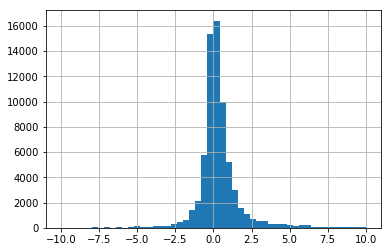

In [10]:
merged_cleaned[abs(merged_cleaned.surprise_median_fa)<10]['surprise_median_fa'].hist(bins=50)

In [11]:
merged_cleaned['kurtosis_mean']=merged_cleaned['surprise_mean_fa'].kurt()
merged_cleaned['kurtosis_median']=merged_cleaned['surprise_median_fa'].kurt()

/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


●	How do your pre-post earnings price time series from the previous section look as a function of conditioning on different values of the surprise metrics (and distribution metrics) above?

In [59]:
price_distributions = pd.read_csv('../AFE_data/df_prc_dist.csv')
del price_distributions['Unnamed: 0']
del price_distributions['quarternum']

In [60]:
price_distributions['year'] = price_distributions['ANNDATS'].apply(lambda x: str(x)[:4])

In [123]:
def slice_population_on_variable_for_charts(merged_cleaned,col = 'surprise_mean_fa'):
    qs,bins = pd.qcut(merged_cleaned[col],10,retbins=True)
    quantile_dfs = []
    quantile_populations = {}
    for i in range(0,len(bins)-1):
        print(i,bins[i],bins[i+1])

        quantile_filtered_earnings = merged_cleaned[(merged_cleaned[col]>=bins[i])& 
                                                    (merged_cleaned[col]<bins[i+1])].copy()
        
        quantile_filtered_earnings = quantile_filtered_earnings[['TICKER','year']].drop_duplicates()

        price_drift_df = pd.merge(quantile_filtered_earnings,price_distributions,on=['TICKER','year'])

        df = price_drift_df[list(map(str,list(range(-30,31,1))))].mean().copy()
        df.name = 'quantile_' + str(i)

        quantile_populations[i] = price_drift_df[list(map(str,list(range(-30,31,1))))].copy()

        quantile_dfs.append(df)

    return {'quantile_dfs':quantile_dfs,'quantile_populations':quantile_populations}


In [124]:
df = slice_population_on_variable_for_charts(merged_cleaned=merged_cleaned.copy(),col = 'surprise_mean_fa')

populations = df['quantile_populations']
df = df['quantile_dfs']

0 0.000346410161514 0.0534967733784
1 0.0534967733784 0.0874948978104
2 0.0874948978104 0.123847063906
3 0.123847063906 0.166014641255
4 0.166014641255 0.228142698566
5 0.228142698566 0.314852002614
6 0.314852002614 0.426140390921
7 0.426140390921 0.622185361854
8 0.622185361854 1.08807477449
9 1.08807477449 48.6736009578


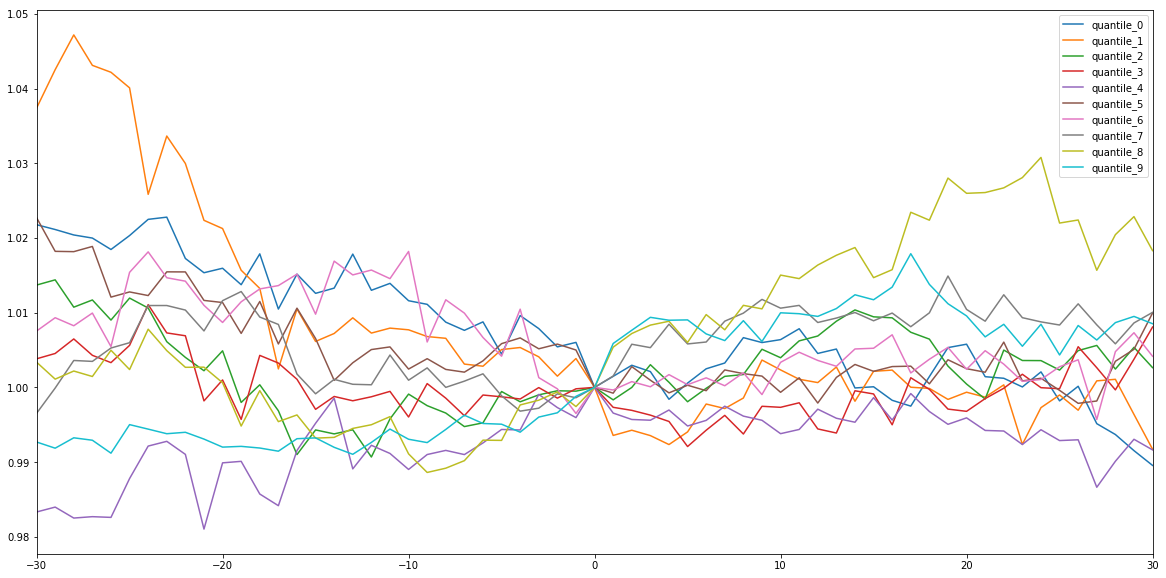

In [125]:
df = pd.concat(quantile_dfs,axis=1)
df.index = list(map(float,df.index))
(df).plot(figsize=[20,10])

In [126]:
df.iloc[-61]

quantile_0    1.021778
quantile_1    1.037388
quantile_2    1.013698
quantile_3    1.003823
quantile_4    0.983314
quantile_5    1.022720
quantile_6    1.007540
quantile_7    0.996523
quantile_8    1.003373
quantile_9    0.992683
Name: -30.0, dtype: float64

<h2>Earnings quantile sorted mean surprise - pre drift</h2>

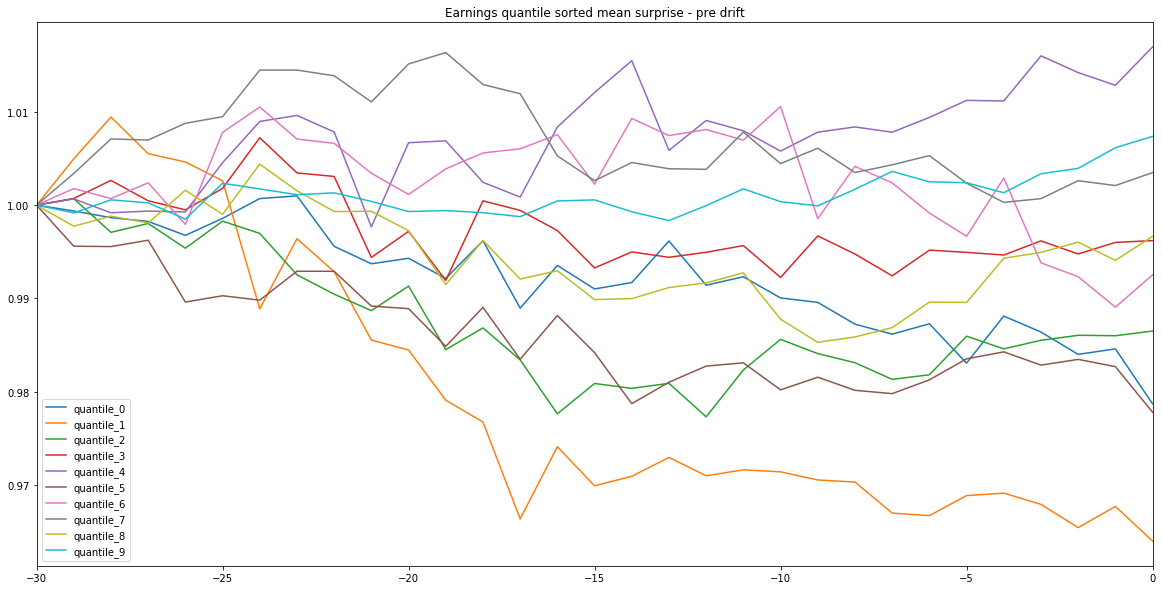

In [127]:
(df[df.index<=0]/df.iloc[-61]).plot(figsize=[20,10],title='Earnings quantile sorted mean surprise - pre drift')

<h3>Performance pre drift spread</h3>

In [128]:
(df[df.index<=0]/df.iloc[-61]).ix[0]['quantile_9']-(df[df.index<=0]/df.iloc[-61]).ix[0]['quantile_0']

/home/jasonmellone/anaconda2/envs/py3dsqf/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


0.028684492340636303

<h2>Quantile Sorted Mean Surprise Post drift</h2>

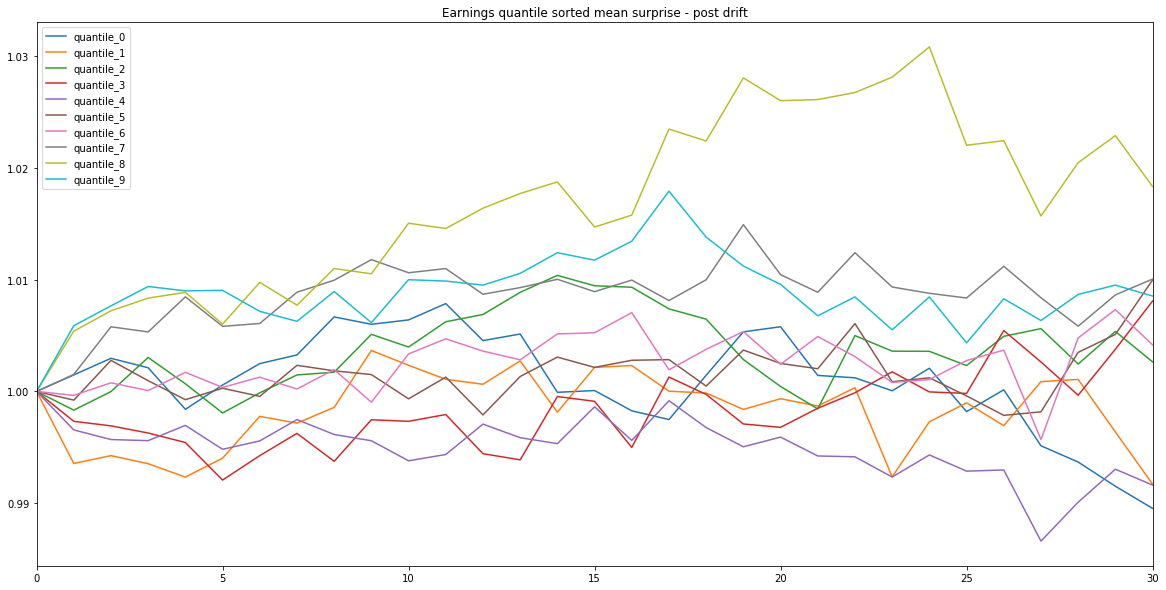

In [129]:
(df[df.index>=0]).plot(figsize=[20,10],title='Earnings quantile sorted mean surprise - post drift')

<h3>Performance post drift spread</h3>

In [130]:
(df[df.index>=0]).iloc[-1]['quantile_9']-(df[df.index>=0]).iloc[-1]['quantile_0']

0.018975355054302367